# NATRE

Reproducing the Ferrari & Polzin (2005) estimate using NATRE data, and comparing differences with our version

In [1]:
import glob

import cf_xarray as cfxr
import dcpy
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
from IPython.display import Image

xr.set_options(keep_attrs=True)
mpl.rcParams["figure.dpi"] = 140

In [2]:
import distributed

if "client" in locals():
    client.cluster.close()
    client.close()
client = distributed.Client(n_workers=4, threads_per_worker=1,)

In [3]:
client

<Client: 'tcp://127.0.0.1:37069' processes=4 threads=4, memory=33.39 GB>

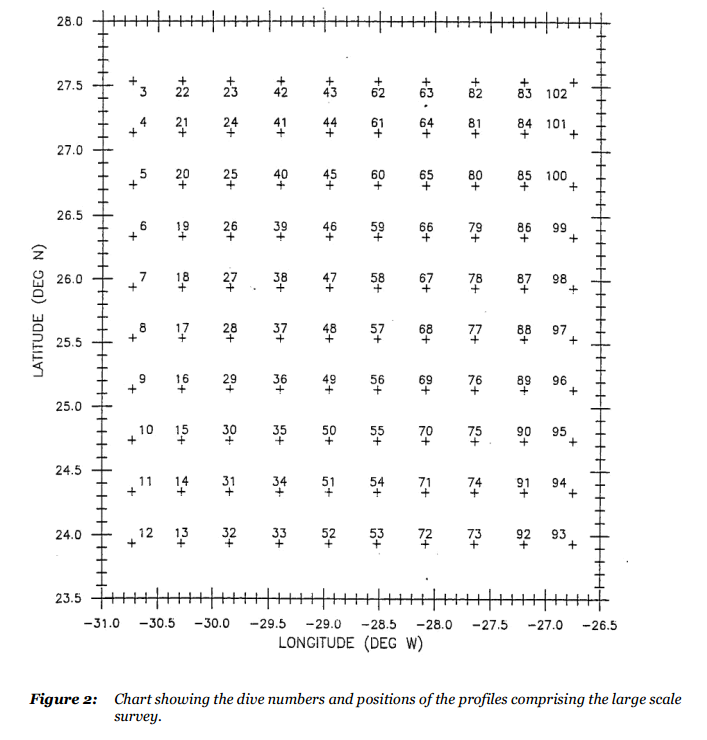

In [4]:
Image("../images/natre-large-scale.png")

## Read dataset

created using ``eddydiff.natre.combine_natre_files()``



In [5]:
natre = xr.open_dataset("../datasets/natre_large_scale.nc").load()
natre = natre.cf.guess_coord_axis()
natre["theta"] = dcpy.eos.ptmp(natre.salt, natre.temp, natre.pres, pr=1000)
natre["pden"] =  dcpy.eos.pden(natre.salt, natre.temp, natre.pres, pr=1000)
natre

<xarray.Dataset>
Dimensions:             (depth: 7961, latitude: 10, longitude: 10)
Coordinates:
  * depth               (depth) float64 10.2 10.6 11.0 ... 3.194e+03 3.194e+03
  * latitude            (latitude) float64 27.5 27.1 26.7 ... 24.7 24.3 23.9
  * longitude           (longitude) float64 -30.7 -30.3 -29.8 ... -27.2 -26.8
    reference_pressure  int64 1000
Data variables:
    chi                 (latitude, longitude, depth) float64 nan nan ... nan nan
    eps                 (latitude, longitude, depth) float64 nan nan ... nan nan
    pres                (latitude, longitude, depth) float64 nan nan ... nan nan
    salt                (latitude, longitude, depth) float64 nan nan ... nan nan
    temp                (latitude, longitude, depth) float64 nan nan ... nan nan
    time                (latitude, longitude) datetime64[ns] 1992-03-28T15:28...
    theta               (latitude, longitude, depth) float64 nan nan ... nan nan
    pden                (latitude, longitude, depth) float64 nan nan ... nan nan
Attributes: (12/13)
    Conventions:           CF-1.6
    netcdf_version:        4
    project:               North Atlantic Tracer Release Experiment (NATRE)
    expocode:              32OC250_4
    cast_number:           3.0
    title:                 Microstructure profiler data from the ship Oceanus...
    ...                    ...
    latitude:              27.533166666666666
    longitude:             -30.723333333333333
    chief_scientist:       Raymond W. Schmitt
    data_originator:       Polzin
    institution:           WHOI
    data_assembly_center:  CCHDO

In [173]:
(
    natre["chi"]
    .where(natre.chi > 1e-14)
    .rolling(depth=250, center=True, min_periods=1)
    .mean()
    .compute()
).plot.line(
    y="depth",
    col="longitude",
    row="latitude",
    # norm=mpl.colors.LogNorm(1e-12, 1e-5),
    # cmap=mpl.cm.Spectral_r,
    yincrease=False,
    xlim=[1e-12, 1e-7],
    ylim=(2000, 0),
    xscale="log",
    # robust=True,
    # col_wrap=4,
)

## Procedure

The large-scale average operator ⟨⟩ represents 
1. a horizontal average over the survey lateral scale,
2. a vertical average over O(100) m, and
3. a time average over the 18-day survey.


The mean fields are derived by averaging all variables along neutral-density surfaces $γ_n$

Mean vertical gradients $∂_z θ_m$, $∂_z S_m$, and $∂_z b_m$, are calculated from O(100)-m linear fits to $θ_m(z_n)$,
$S_m(z_n)$, and $b_m(z_n)$, where $z_n$ is the mean depth of each surface $γ_n$. 

large-scale temperature gradient $|∇_n θ_m|$ is estimated by fitting
a plane to the 100 stations in the 400 km × 400 km
large-scale survey grid and rms is computed as the standard deviation of the departures from the plane fit. 

In theory, these bins are approx. 100m apart in neutral density

### Choose bins

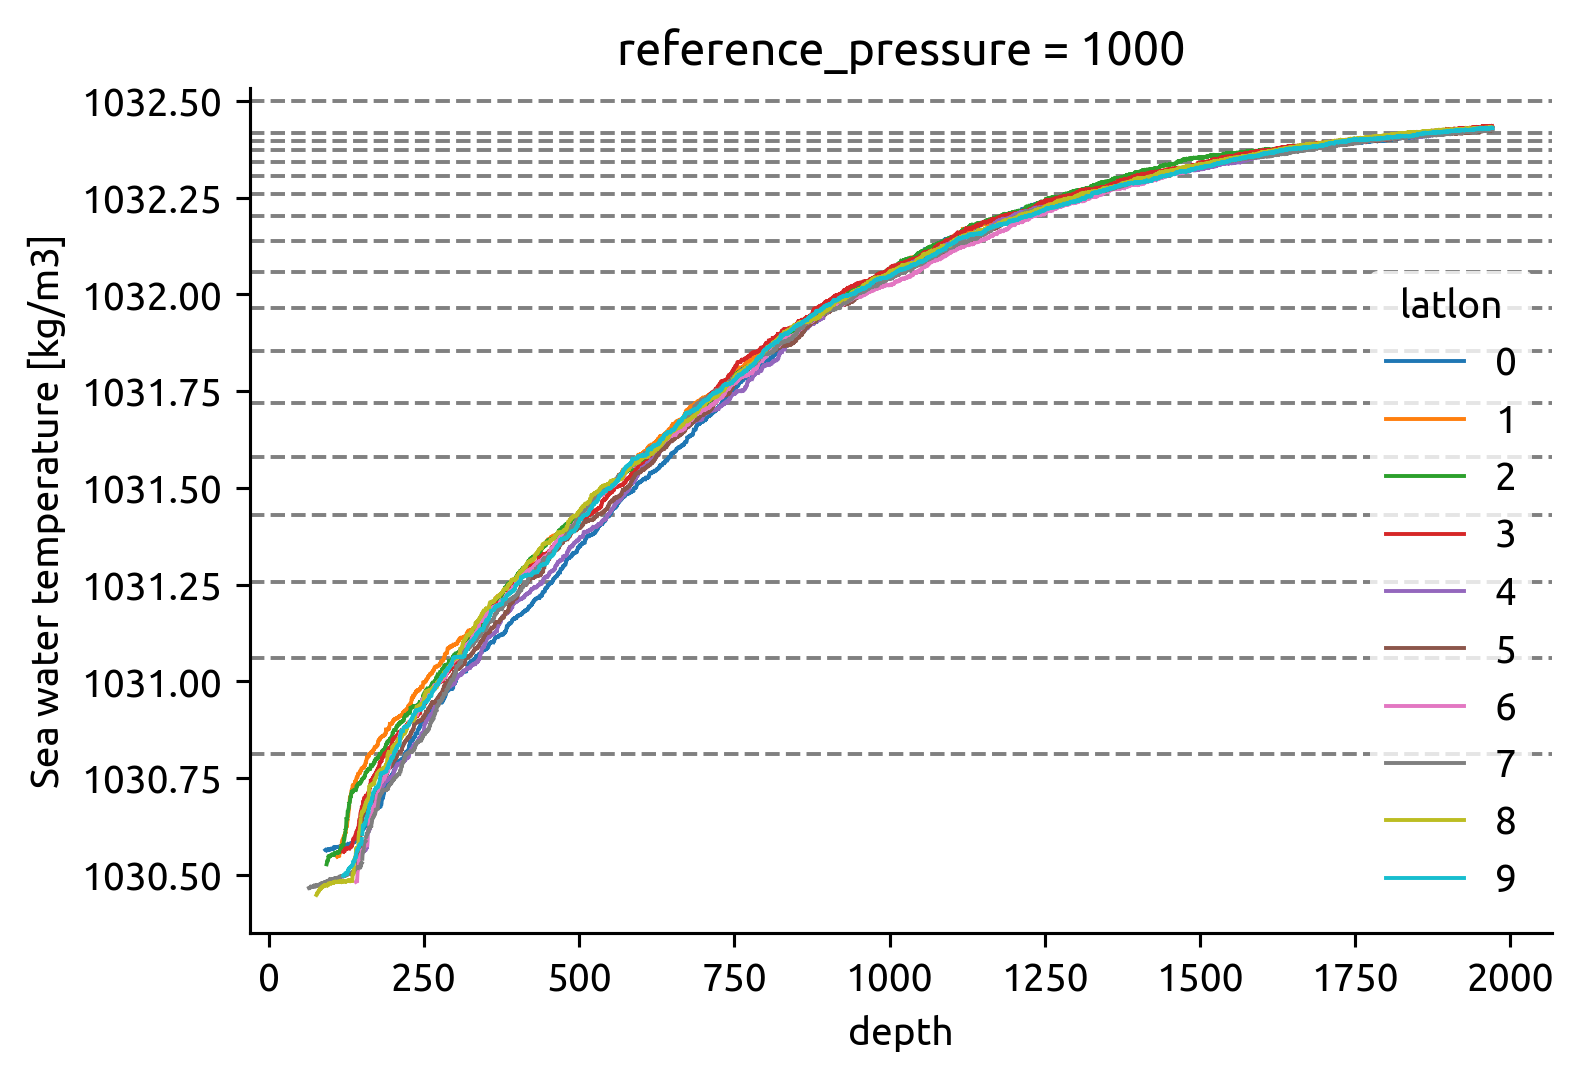

In [170]:
# bins = np.arange(1026.5, 1028.7, 0.2)
bins = [
    1030.81154836,
    1031.05957777,
    1031.25784152,
    1031.42899149,
    1031.57905569,
    1031.72019646,
    1031.85230913,
    1031.9654204,
    1032.05809164,
    1032.13639824,
    1032.20300346,
    1032.25857768,
    1032.30501071,
    1032.34271354,
    1032.3724109,
    1032.39573096,
    1032.41578357,
    1032.5
]
natre.pden.stack(latlon=["latitude", "longitude"]).drop("latlon").isel(latlon=slice(None, None, 10)).cf.plot.line(hue="latlon")
dcpy.plots.liney(bins)

Test that χ looks OK

/home/deepak/miniconda3/envs/dcpy/lib/python3.7/site-packages/IPython/core/pylabtools.py:132: UserWarning: constrained_layout not applied.  At least one axes collapsed to zero width or height.
  fig.canvas.print_figure(bytes_io, **kw)


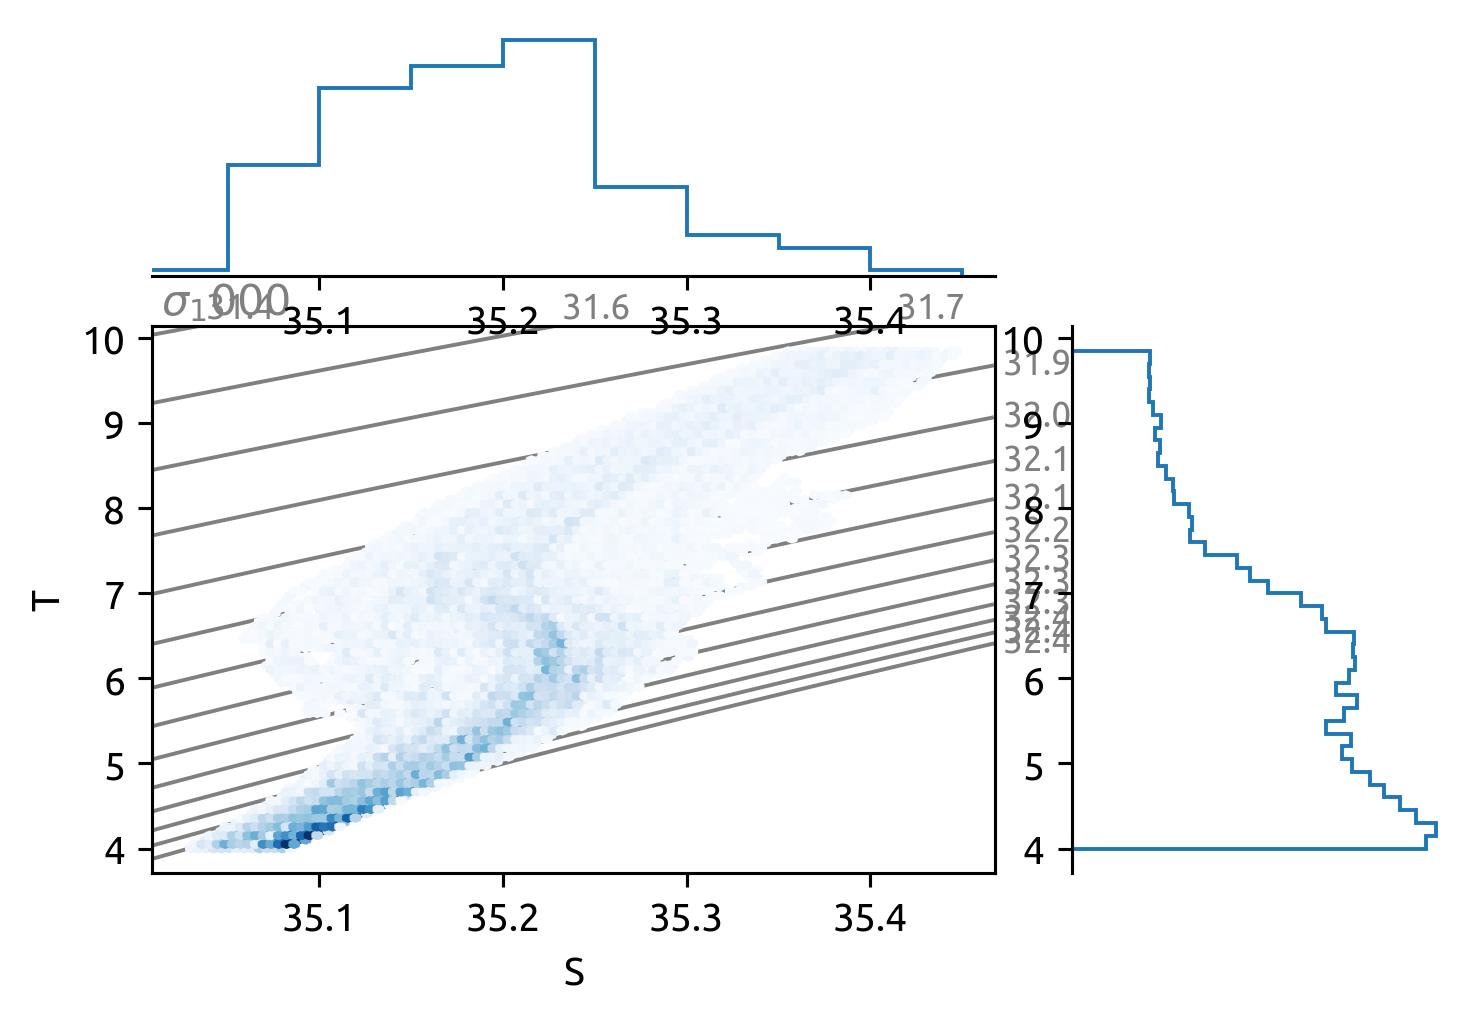

In [9]:
hdl, axes = dcpy.oceans.TSplot(
    natre.salt,
    natre.theta,
    Pref=1000,
    rho_levels=bins,
    Sbins=np.arange(35, 35.5, 0.05),
    Tbins=np.arange(4, 10, 0.15),
)

## Make estimate

In [174]:
natre["Tz_local"] = -1 * natre.theta.interpolate_na("depth").differentiate("depth")
natre["KtTz"].attrs["long_name"] = "$T_z^l$"
natre["KtTz"] = natre.chi / 2 / natre.Tz_local
natre["KtTz"].attrs["long_name"] = "$K_t T_z^l$"

In [205]:
grouped = natre.groupby_bins("pden", bins=bins)
chidens = grouped.mean()
chidens["pden_bins"].attrs = natre.pden.attrs
chidens["pden_bins"].attrs["positive"] = "down"
chidens["pden_bins"].attrs["axis"] = "Z"
chidens = chidens.set_coords("pres")
chidens["pres"].attrs["positive"] = "down"
chidens

<xarray.Dataset>
Dimensions:             (pden_bins: 17)
Coordinates:
  * pden_bins           (pden_bins) object (1030.812, 1031.06] ... (1032.416,...
    pres                (pden_bins) float64 244.1 347.8 ... 1.75e+03 1.969e+03
    reference_pressure  int64 1000
Data variables:
    chi                 (pden_bins) float64 9.241e-09 5.039e-09 ... 2.401e-10
    eps                 (pden_bins) float64 7.529e-10 5.874e-10 ... 1.314e-10
    salt                (pden_bins) float64 36.38 36.02 35.78 ... 35.12 35.08
    temp                (pden_bins) float64 16.82 14.83 13.23 ... 4.684 4.161
    theta               (pden_bins) float64 16.95 14.94 13.31 ... 4.613 4.071
    pden                (pden_bins) float64 1.031e+03 1.031e+03 ... 1.032e+03
    Tz_local            (pden_bins) float64 0.0231 0.01946 ... 0.003178 0.0027
    KtTz                (pden_bins) float64 1.958e-07 1.365e-07 ... -6.919e-07
Attributes: (12/13)
    Conventions:           CF-1.6
    netcdf_version:        4
    project:               North Atlantic Tracer Release Experiment (NATRE)
    expocode:              32OC250_4
    cast_number:           3.0
    title:                 Microstructure profiler data from the ship Oceanus...
    ...                    ...
    latitude:              27.533166666666666
    longitude:             -30.723333333333333
    chief_scientist:       Raymond W. Schmitt
    data_originator:       Polzin
    institution:           WHOI
    data_assembly_center:  CCHDO

### Vertical gradients

Mean vertical gradients $∂_z θ_m$, $∂_z S_m$, and $∂_z b_m$, are calculated from O(100)-m linear fits to $θ_m(z_n)$,
$S_m(z_n)$, and $b_m(z_n)$, where $z_n$ is the mean depth of each surface $γ_n$. 

<xarray.DataArray 'polyfit_coefficients' ()>
array(-0.00287186)

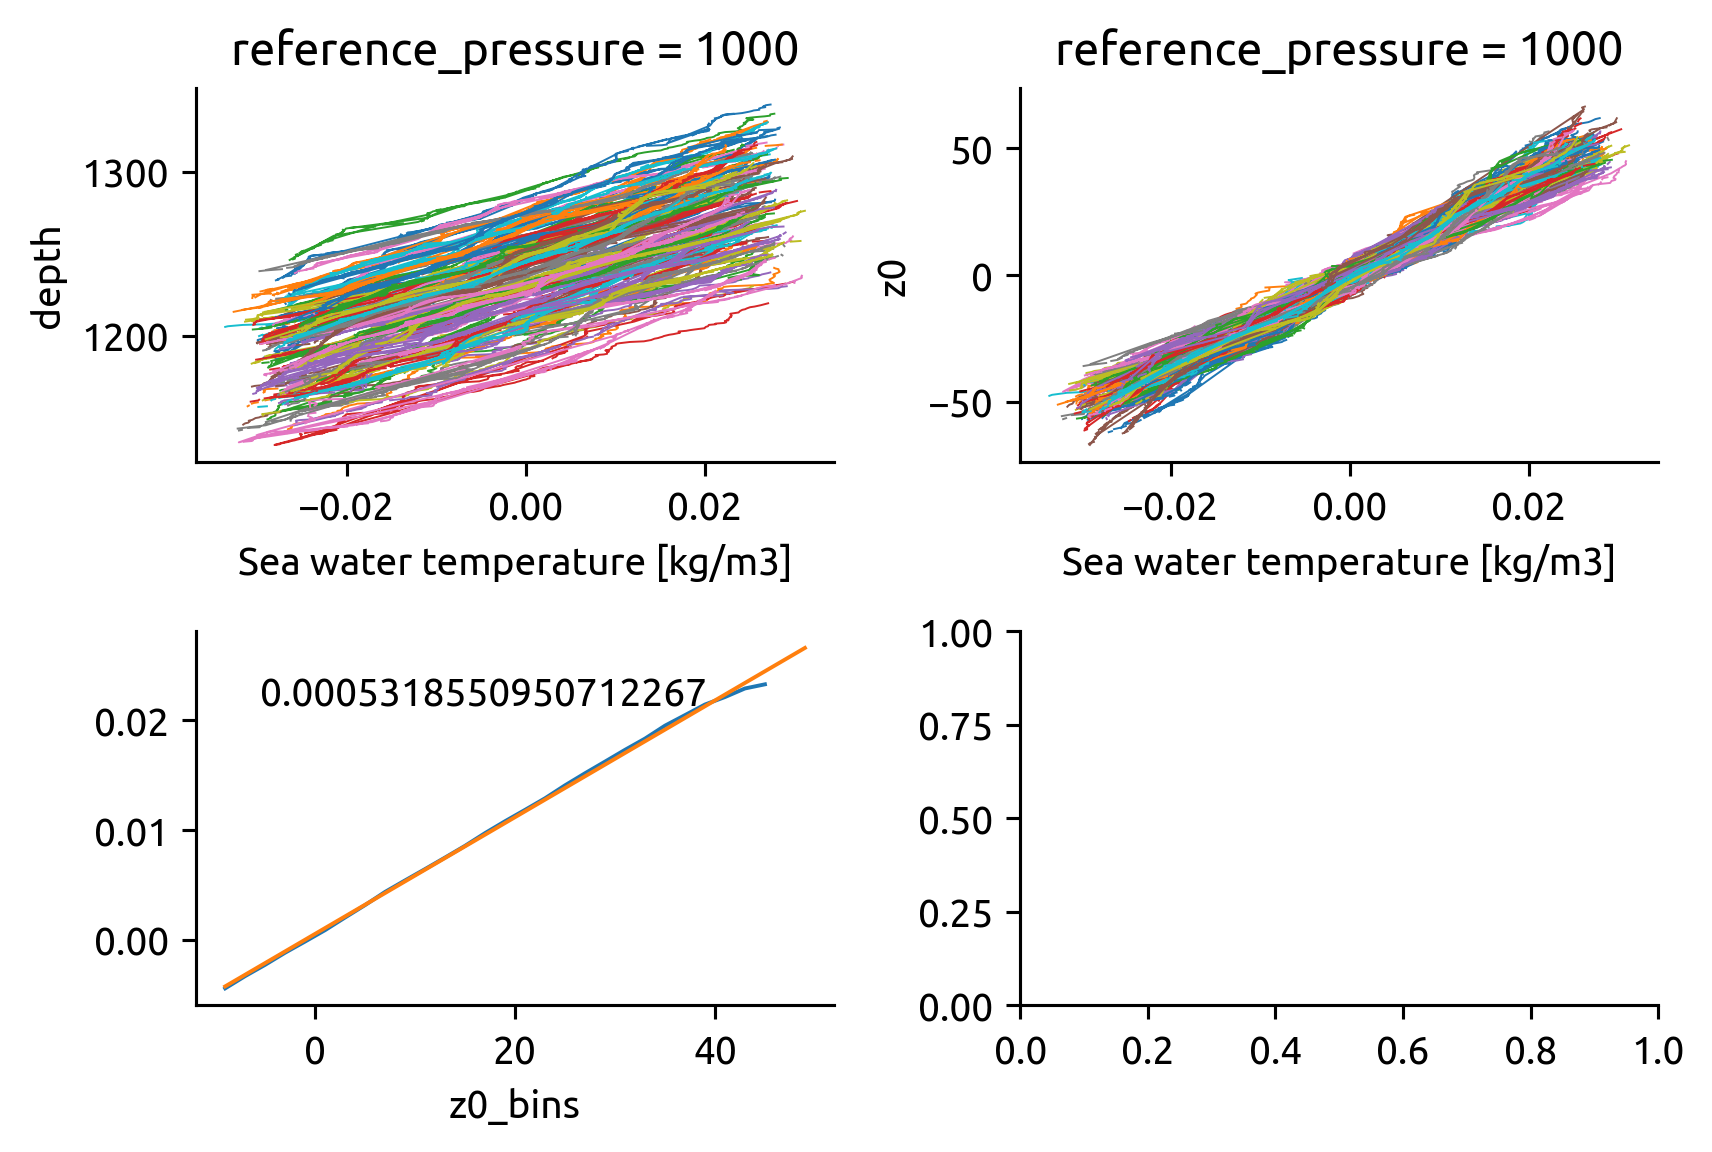

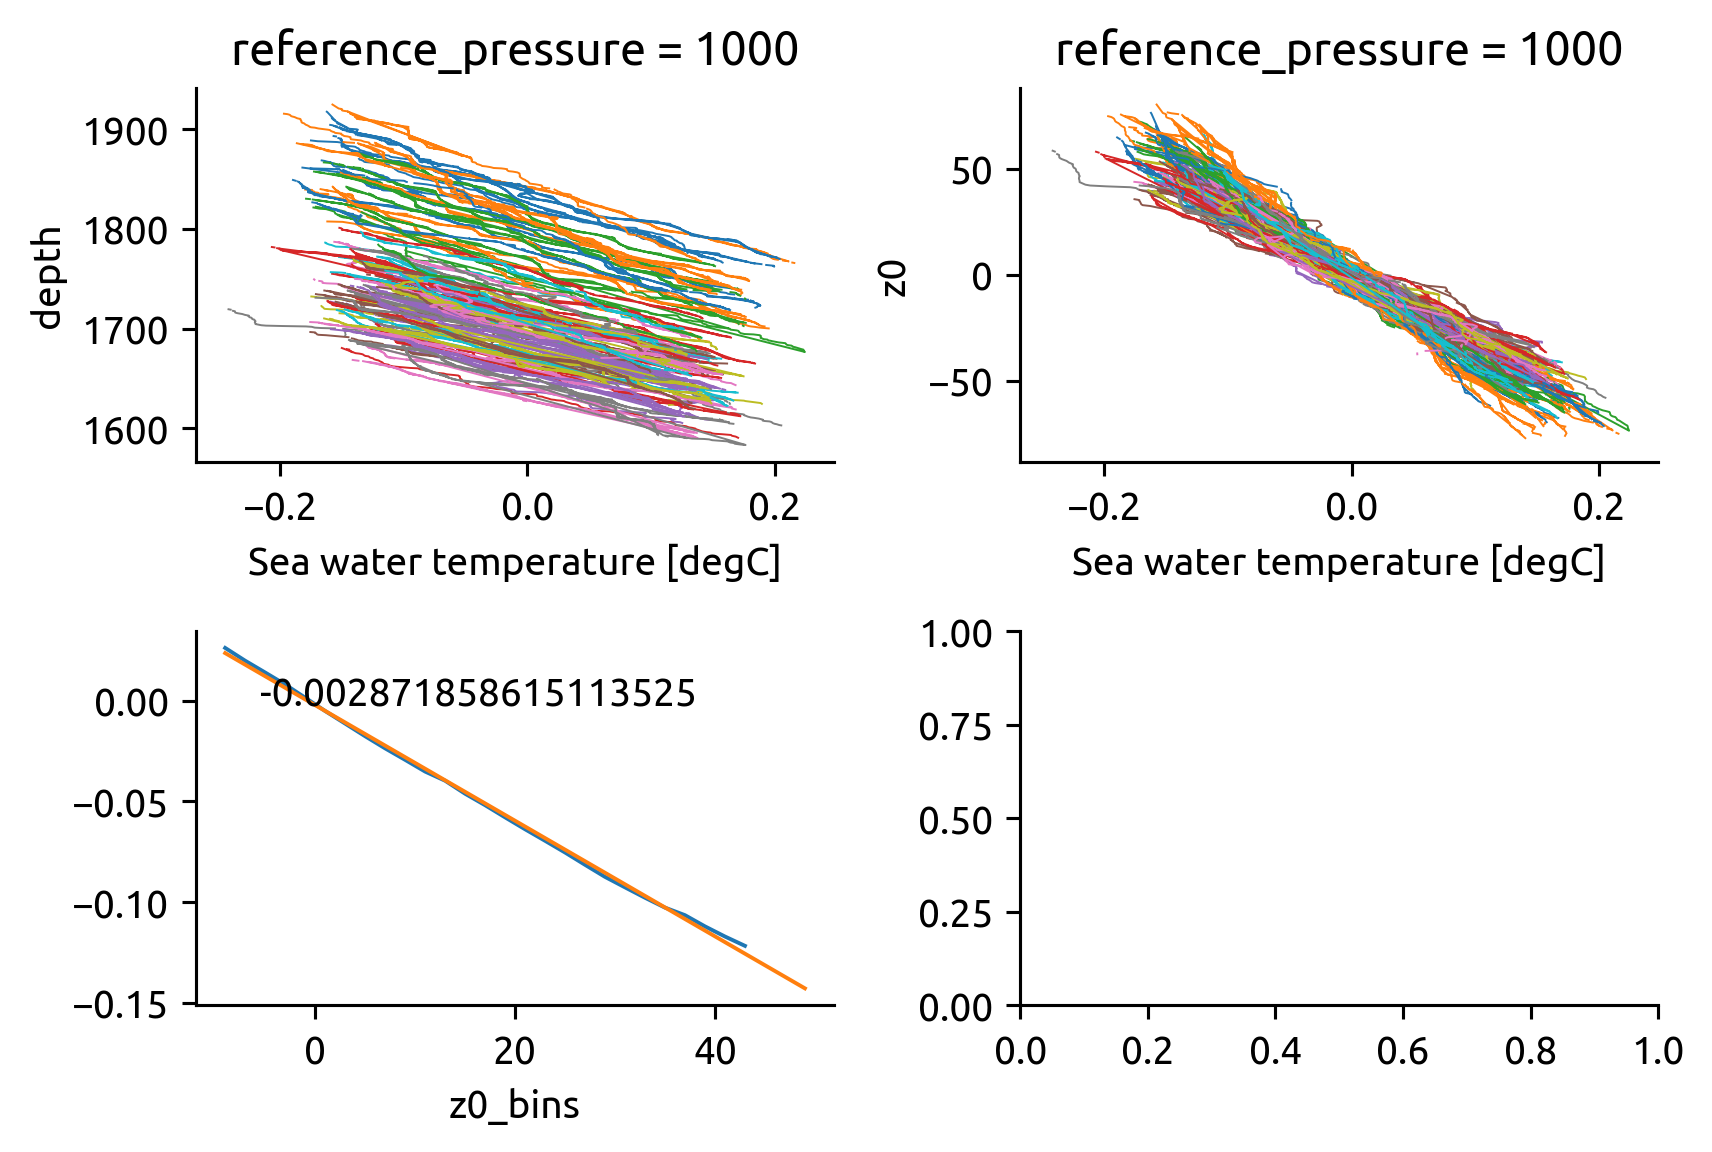

In [206]:
def fit1D(group, var, dim="depth", debug=False):
    """
    Expects a bunch of profiles at differ lat, lons.
    Calculates mean profile and then takes linear fit to estimate gradient.
    """
    ds = group.unstack()
    stacked = ds[var].stack(latlon=("latitude", "longitude")).drop("latlon")

    # move to a relative-depth reference frame for proper averaging
    stacked["z0"] = stacked[dim] - stacked[dim].where(stacked.notnull()).mean(dim)
    stacked -= stacked.mean(dim)

    if debug:
        f, ax = plt.subplots(2, 2, constrained_layout=True)
        kwargs = dict(add_legend=False, lw=0.5)
        stacked.plot.line(y=dim, ax=ax[0, 0], **kwargs)
        stacked.plot.line(y="z0", **kwargs, ax=ax[0, 1])

    binned = stacked.groupby_bins("z0", bins=np.arange(-10, 200, 2))
    count = binned.count()
    min_count = 300  # count.median() / 1.25
    mean_profile = binned.mean().where(count > min_count)
    mean_profile["z0_bins"] = mean_profile.indexes["z0_bins"].mid

    poly = (mean_profile).polyfit("z0_bins", deg=1)
    slope = poly.polyfit_coefficients.sel(degree=1, drop=True)

    if debug:
        mean_profile.plot(ax=ax[1, 0])
        xr.polyval(
            mean_profile.z0_bins.sel(z0_bins=slice(50)), poly.polyfit_coefficients
        ).plot(ax=ax[1, 0])
        ax[1, 0].text(x=0.1, y=0.8, s=str(slope.item()), transform=ax[1, 0].transAxes)

    return slope


for idx, (label, group) in enumerate(grouped):
    if idx == 10:
        break

fit1D(group, var="pden", debug=True)

for idx, (label, group) in enumerate(grouped):
    if idx == 15:
        break

fit1D(group, var="theta", debug=True)

In [209]:
chidens["dTdz"] = -1 * grouped.apply(fit1D, var="theta", dim="depth")
chidens.dTdz.attrs.update(dict(name = "$∂T/∂z$", units = "°C/m"))

chidens["N2"] = 9.81 / 1030 * grouped.apply(fit1D, var="pden", dim="depth")
chidens.N2.attrs.update(dict(name = "$N²$", units = "s$^{-2}$"))

chidens["Krho"] = 0.2 * chidens.eps / chidens.N2
chidens.Krho.attrs.update(dict(long_name="$K_ρ$", units="m²/s"))

### Horizontal gradients

large-scale temperature gradient $|∇_n θ_m|$ is estimated by fitting
a plane to the 100 stations in the 400 km × 400 km
large-scale survey grid and rms is computed as the standard deviation of the departures from the plane fit. 

In [213]:
def fit2D(group, debug=False):
    from scipy.interpolate import RectBivariateSpline

    pden = (
        group.unstack()
        .mean("depth")
        .theta.sortby("latitude")
        # .isel(longitude=slice(1, -1), latitude=slice(1, -1))
    )
    pden = pden.cf.guess_coord_axis()
    x, y = dcpy.util.latlon_to_xy(pden.cf["latitude"], pden.cf["longitude"])
    x -= x.min()
    y -= y.min()
    pden.coords["x"] = x.mean("latitude")
    pden.coords["y"] = y.mean("longitude")
    if debug:
        plt.figure()
        pden.cf.plot()

    spl = RectBivariateSpline(
        x=pden.cf["X"].data, y=pden.cf["Y"].data, z=pden.data, kx=1, ky=1, s=1
    )
    if debug:
        print(spl.get_residual())

    fit = pden.copy(data=spl(pden.cf["X"], pden.cf["Y"]))
    test = xr.concat([pden, fit], dim=xr.Variable("kind", ["actual", "fit"]))

    if debug:
        plt.figure()
        fit.cf.plot()

        plt.figure()
        test.isel(longitude=5).plot(hue="kind")

        plt.figure()
        test.isel(latitude=6).plot(hue="kind")

    slope = xr.Dataset()
    slope["x"] = (
        fit.polyfit("longitude", deg=1, use_coordinate="x")
        .sel(degree=1, drop=True)
        .median()
        .to_array()
    )
    slope["y"] = (
        fit.polyfit("latitude", deg=1, use_coordinate="y")
        .sel(degree=1, drop=True)
        .median()
        .to_array()
    )
    slope = slope.squeeze().drop_vars("variable") #.expand_dims(pden_bins=[label])
    return slope

In [214]:
iso_slope = grouped.apply(fit2D)
chidens["dTiso"] = np.hypot(iso_slope.x, iso_slope.y)
chidens["dTiso"]

<xarray.DataArray 'dTiso' (pden_bins: 17)>
array([1.80672143e-06, 5.08315215e-07, 7.30616925e-07, 4.54924529e-07,
       1.94180184e-06, 4.48256204e-06, 7.06458679e-06, 6.61356066e-06,
       7.25958151e-06, 6.21228760e-06, 6.02759332e-06, 5.50886752e-06,
       5.91650970e-06, 5.82697815e-06, 5.50171177e-06, 5.13534030e-06,
       2.84431704e-06])
Coordinates:
  * pden_bins           (pden_bins) object (1030.812, 1031.06] ... (1032.416,...
    pres                (pden_bins) float64 244.1 347.8 ... 1.75e+03 1.969e+03
    reference_pressure  int64 1000

### Checking estimate

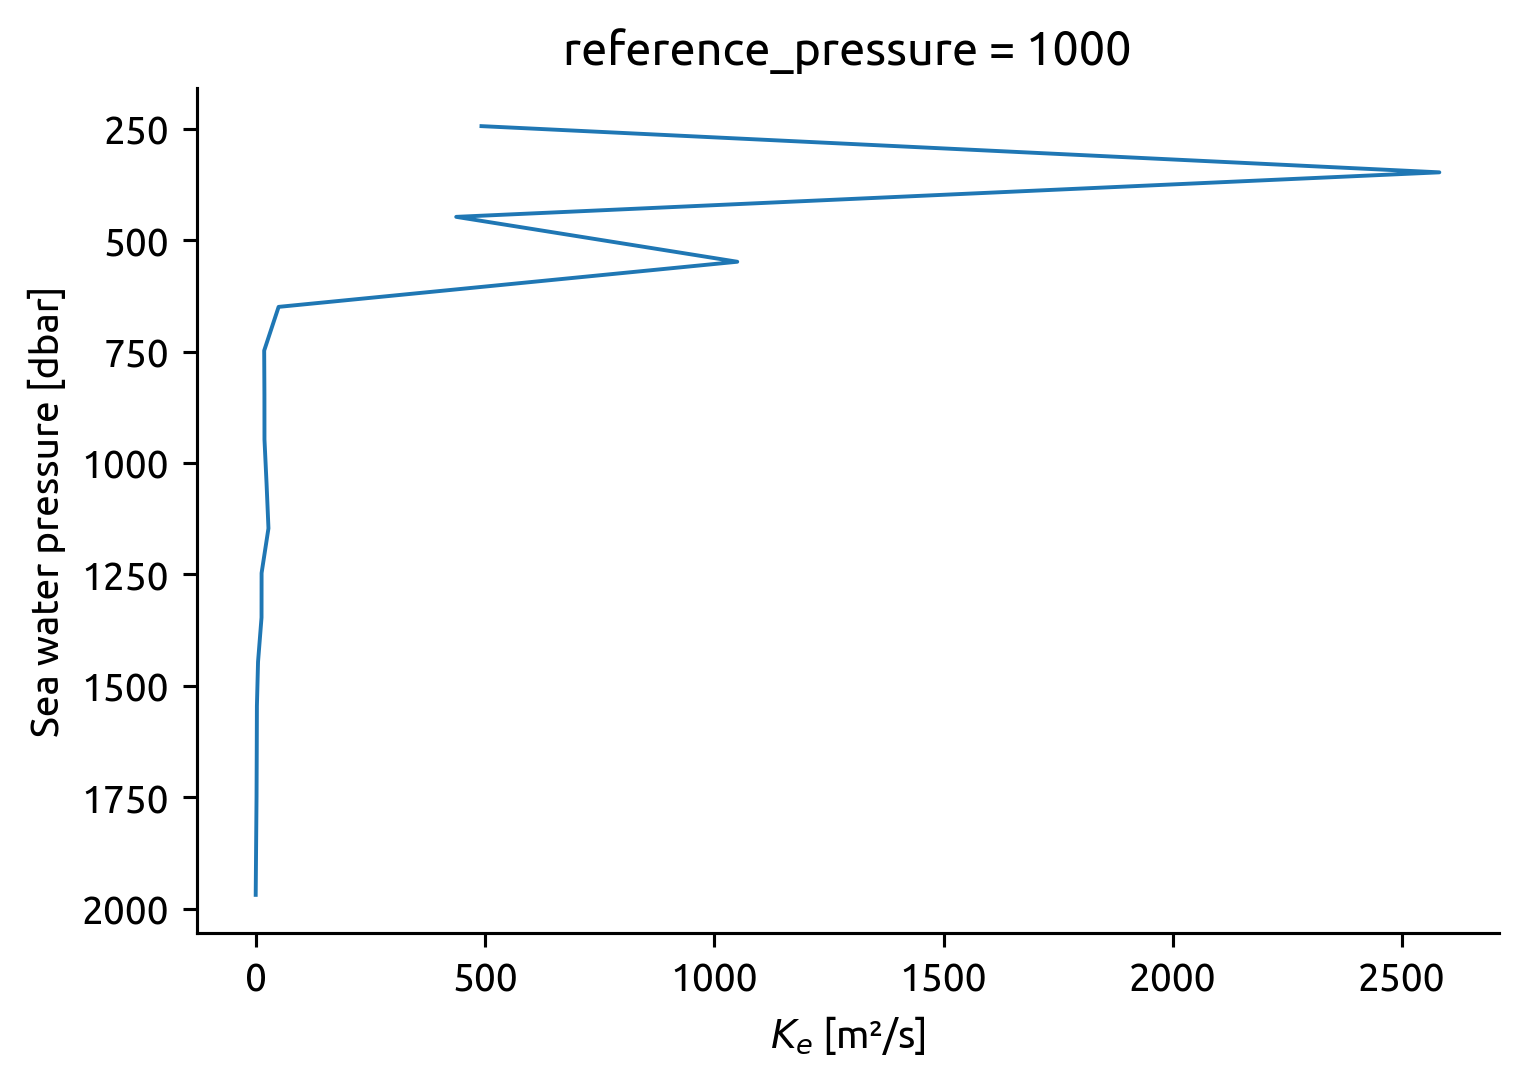

In [215]:
chidens["Ke"] = (chidens.chi/2 - chidens.Krho * chidens.dTdz**2) / chidens.dTiso ** 2
chidens["Ke"].attrs["long_name"] = '$K_e$'
chidens["Ke"].attrs["units"] = "m²/s"
chidens["Ke"].cf.plot()

Replicate some Ferrari & Polzin (2005) figures. $K_ρ, ε$ look OK. $K_e$ is wrong, something is wrong with my slope estimate / plane fitting

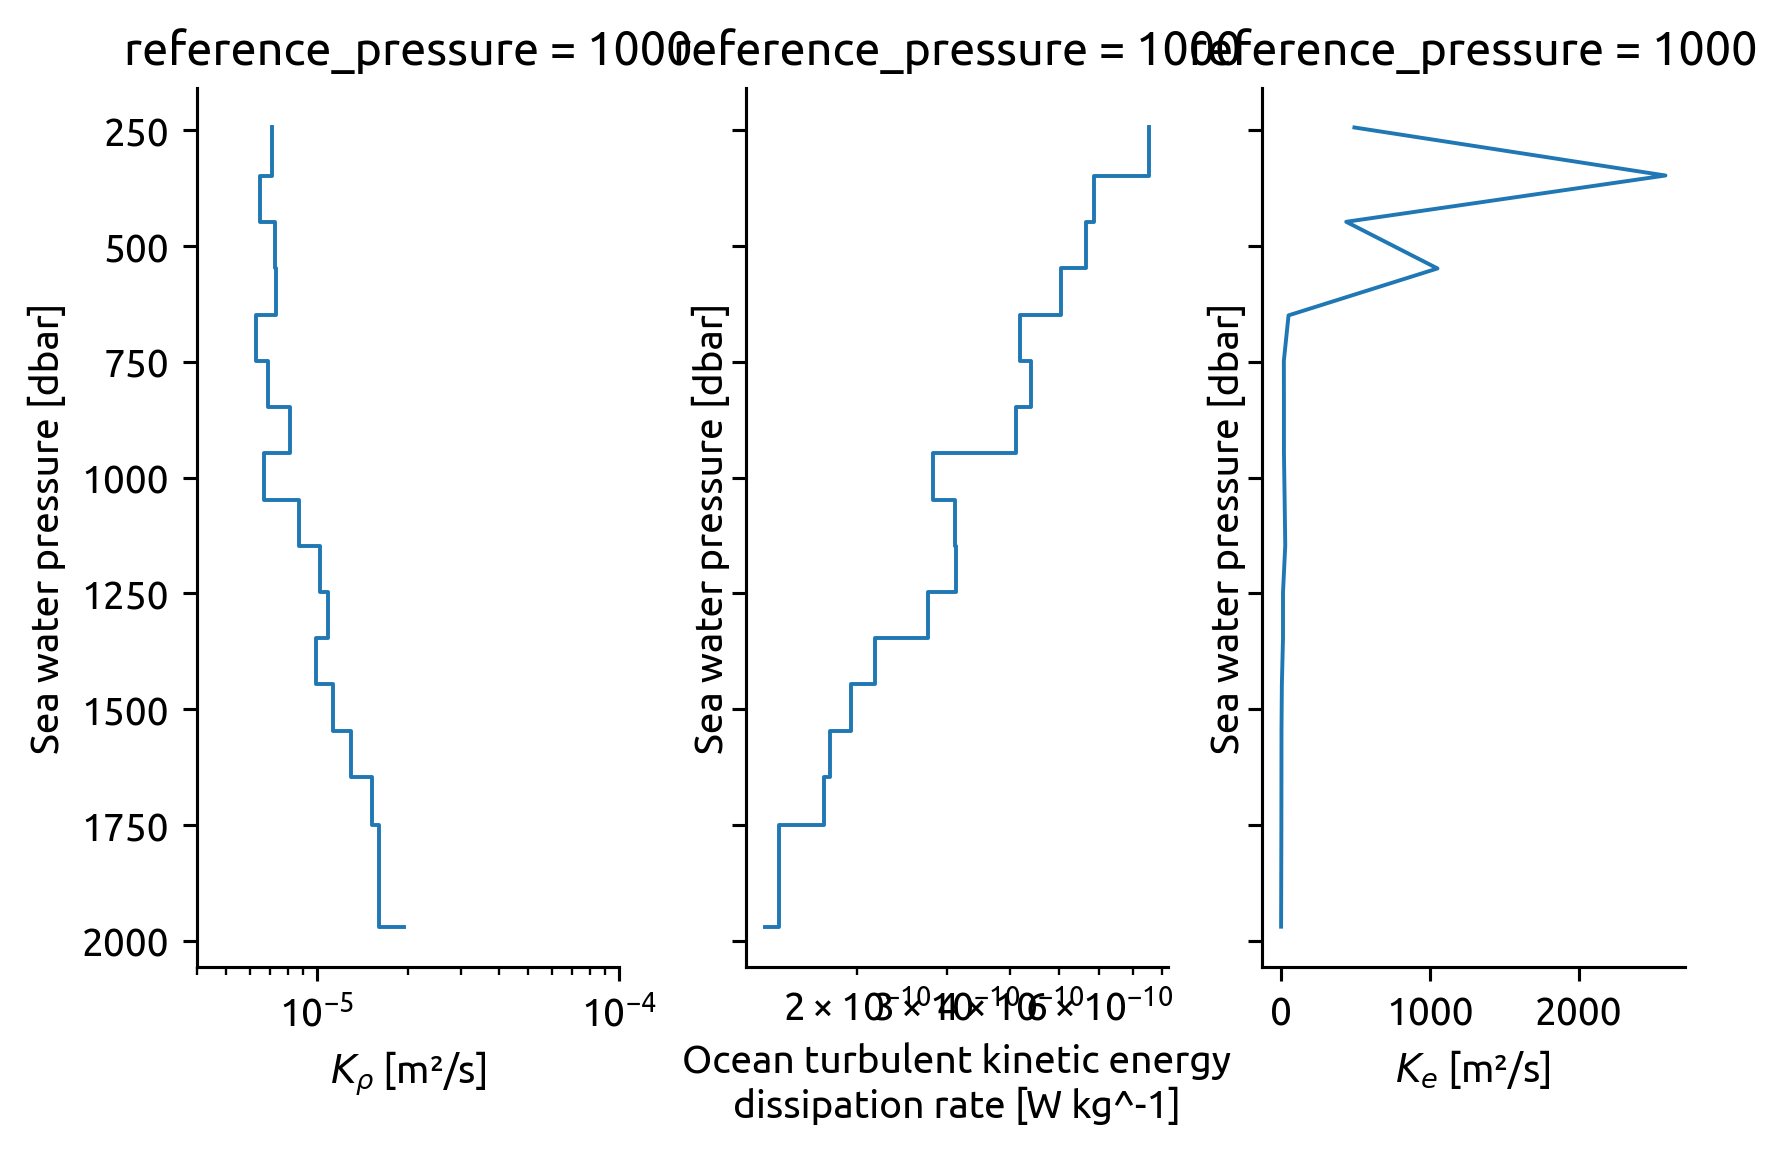

In [216]:
f, ax = plt.subplots(1, 3, sharey=True, constrained_layout=True)
chidens.Krho.cf.plot.step(xscale="log", xlim=(4e-6, 1e-4), ax=ax[0])
chidens.eps.cf.plot.step(ax=ax[1], xscale="log")
chidens["Ke"].cf.plot(ax=ax[2])

## Comparing estimates

Ferrari & Polzin use $⟨u_t θ_t⟩.∇θ_m = -Γ ⟨ε⟩/N_m^2  ∂_zθ_m^2$, we are instead doing $-⟨K_T θ_z⟩ ∂_zθ_m$. Our estimate mostly agrees with theirs. 


1. Filling in NaNs in the temperature profiles was importan. This means more estimates are used in the averages

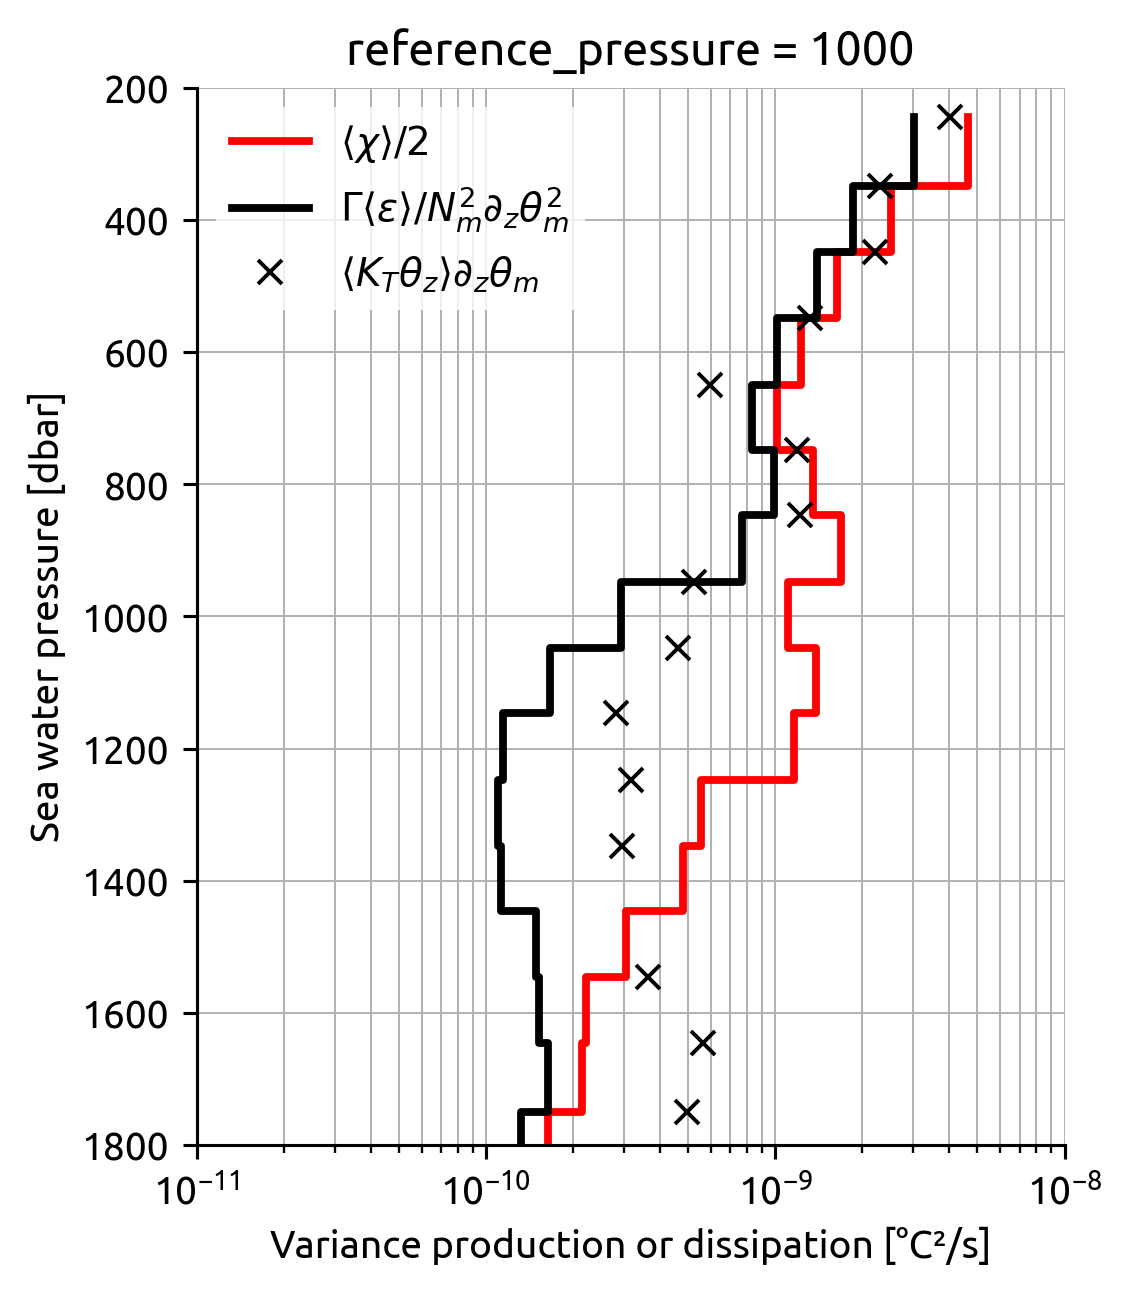

In [217]:
(chidens.chi / 2).cf.plot.step(
    y="pres",
    xscale="log",
    xlim=(1e-11, 1e-8),
    ylim=(1800, 200),
    color="r",
    lw=2,
    label="$⟨χ⟩/2$",
)
(chidens.Krho * chidens.dTdz ** 2).cf.plot.step(color="k", lw=2, label="$Γ ⟨ε⟩/N_m^2  ∂_zθ_m^2$")
plt.grid(True, which="both", lw=0.5)

(chidens.KtTz * chidens.dTdz).cf.plot.step(
    color="k", marker="x", ls="none", label="$⟨K_T θ_z⟩ ∂_zθ_m$"
)
#(chidens.chi / 2 - chidens.Krho * chidens.dTdz ** 2).cf.plot.step(
#    y="pres",
#    xscale="log",
#    xlim=(1e-11, 1e-8),
#    ylim=(1800, 200),
#    color="darkblue",
#    lw=1,
#    label="$⟨χ⟩/2 - K_ρ θ^m_z$",
#)
plt.legend()
plt.xlabel("Variance production or dissipation [°C²/s]")
plt.gcf().set_size_inches((4, 5))


### Todo:

See sensitivity to using
1. $Γ⟨ε/N²⟩$
2. Use $Γ ⟨ε_χ⟩/N_m^2$
3. Using neutral density bins instead of $σ_{1}$

### Generate nice bins

In [11]:
(
    chidens.pden.dropna("pden_bins")
    .swap_dims({"pden_bins": "pres"})
    .interp(pres=np.arange(100, 2000, 100))
)

<xarray.DataArray 'pden' (pres: 19)>
array([          nan,           nan, 1031.05910221, 1031.25786643,
       1031.4289276 , 1031.57897311, 1031.72026509, 1031.85239499,
       1031.9653696 , 1032.0580463 , 1032.13639245, 1032.20298783,
       1032.25857209, 1032.30490323, 1032.34267842, 1032.37242716,
       1032.3957552 ,           nan,           nan])
Coordinates:
    reference_pressure  int64 1000
  * pres                (pres) int64 100 200 300 400 500 ... 1600 1700 1800 1900
Attributes:
    long_name:      Sea water temperature
    standard_name:  sea_water_potential_density
    units:          kg/m3